In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_5469/2851380134.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(9999, 4)

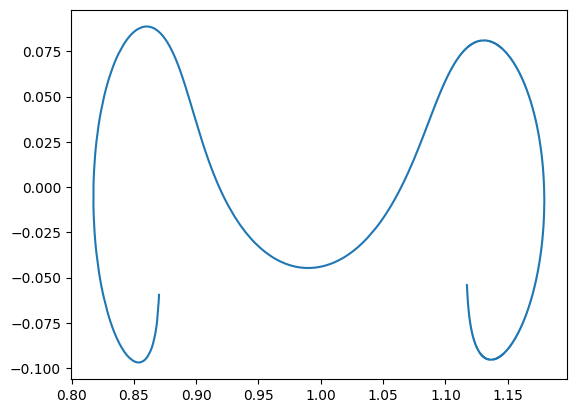

In [3]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [4]:
# three body problem env
import gym
from gym import spaces
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position, axis=0)
        done = self.steps >= self.max_steps
        if abs(self.position - self.trajectory[-1]).sum() < 0.005:
            done = True
            reward = 1000
        if self.steps > 1000:
            done = True
            reward = -1000
        if np.linalg.norm(self.state) > 2:
            done = True
            reward = -1000

        return self.state, reward, done, self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return self.state
    
    def render(self):
        pass

    def close(self):
        pass

    



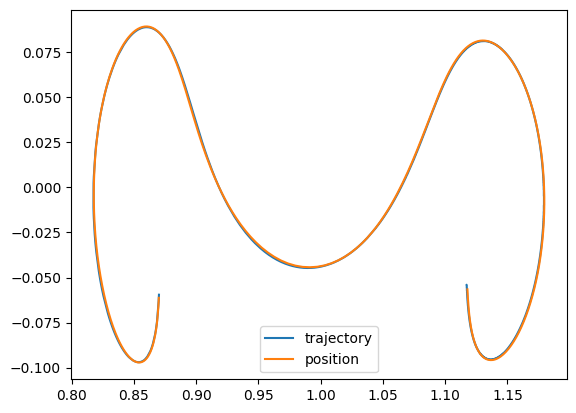

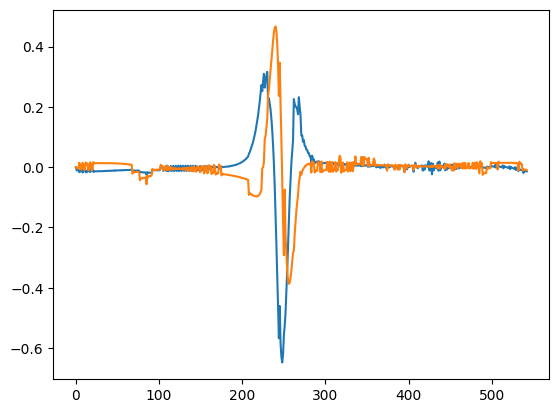

In [5]:
env = three_body_env(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)


In [6]:
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras import layers

def get_actor(num_states, upper_bound):

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh")(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

# train model
x = state_array
y = action_array

# to tensor
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)
model = get_actor(4, 1)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, verbose=1)

# Save the model
model.save('model.h5')

# load model
model = tf.keras.models.load_model('model.h5')

2024-02-06 18:50:29.400107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
17/17 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 11/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 13/100
17/17 [=================

/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


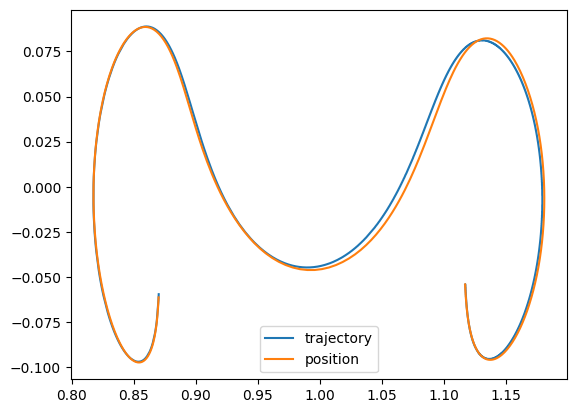

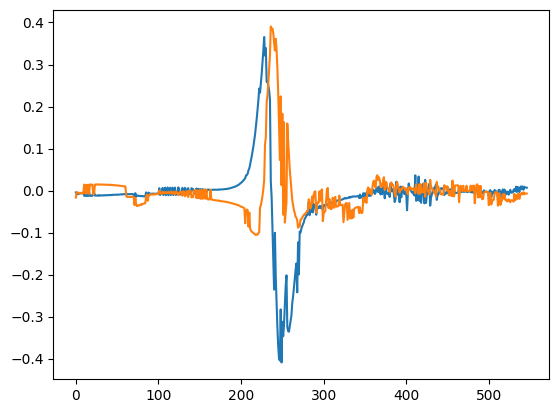

In [7]:
env = three_body_env(trajectory)
state = env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = tf.squeeze(model(state.reshape(1,4)))
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legend
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)

In [8]:
# problem = "Pendulum-v1"
# env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [9]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1][0]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [10]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    model = tf.keras.models.load_model('model.h5')
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [19]:

def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to action
    sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


In [31]:
std_dev = 0.2

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> 1372.1881376146778


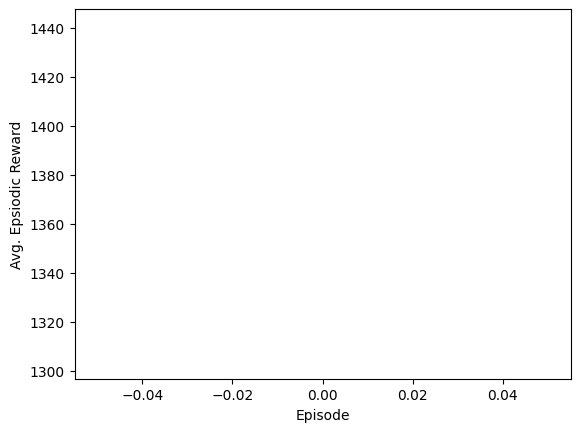

In [32]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state= env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action[0])

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        # buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # early stop unchanged reward
    if ep > 40:
        if np.mean(ep_reward_list[-40:]) == np.mean(ep_reward_list[-41:-1]):
            break
        
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

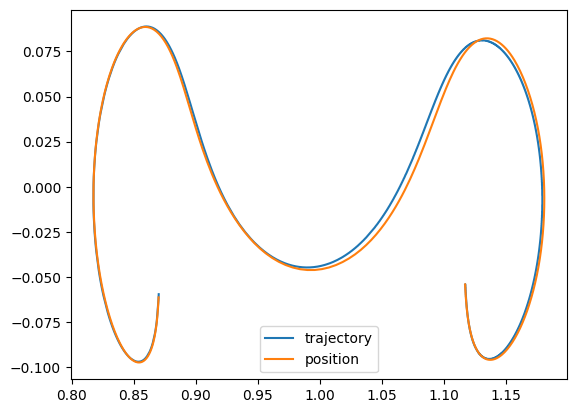

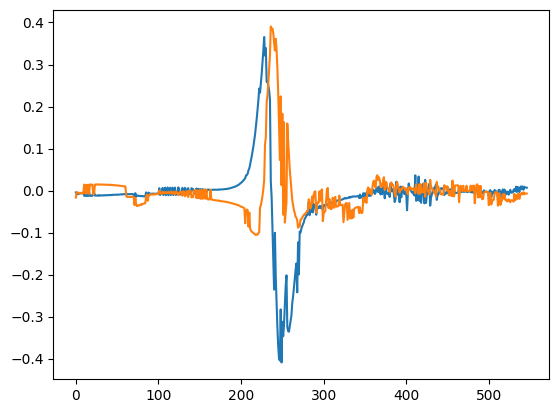

In [33]:
env = three_body_env(trajectory)
state = env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = tf.squeeze(policy(state.reshape(1,4)))
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legend
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)